# Stock Price Prediction

## Problem Statement

Predicting stock price is an intensive and time-consuming task. A sell or buy decision made on the right time can drastically affect your profits.

With wealth of information that is available in the form of historical stock prices and company performance data and the advancement of computing power, machine learning can be used to predict stock price trend using technical analysis, and therefore allowing investors to make sound decisions on when to buy or sell their stocks, thus maximizing the profits.

In in notebook we will work with historical stock data of Intel Inc. We will implement two machine learning algorithms (Moving Average and LSTM) to predict the future daily closing prices of the company, and subsequently choose the best out of the two algorithms to develop our personal stock price predictor.


## Dataset
We will be using the [Intel Inc](https://www.quandl.com/data/EOD/INTC-Intel-Corporation-INTC-Stock-Prices-Dividends-and-Splits) dataset. You can also download the dataset from my Github.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np

# for reproducibility of our results
np.random.seed(1234)

from datetime import date
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.
C:\Apps\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Apps\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Apps\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Apps\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing

In [2]:
# pre-set the plot font sizes...

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)      # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

### Some helper functions

In [3]:
def get_mape(y_true, y_pred): 
    """
    Compute Mean Absolute Percentage Error (MAPE)
    
    INPUT:
    y_true - actual variable
    y_pred - predicted variable
    
    OUTPUT:
    mape - Mean Absolute Percentage Error (%)
    
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return mape

def get_rmse(y_true, y_pred):
    """
    Compute Root Mean Squared Error (RMSE)
    
    INPUT:
    y_true - actual variable
    y_pred - predicted variable
    
    OUTPUT:
    rmse - Root Mean Squared Error
    
    """
    rmse = np.sqrt(np.mean(np.power((y_true - y_pred),2)))
                   
    return rmse

## Exploratory Analysis
Let's import our dataset and have a quick view on it.

In [4]:
# read dataset
df = pd.read_csv('data/EOD-INTC.csv')

In [5]:
# dataframe dimensions
df.shape

(1090, 13)

In [6]:
# column data types
df.dtypes

Date           object
Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
Dividend      float64
Split         float64
Adj_Open      float64
Adj_High      float64
Adj_Low       float64
Adj_Close     float64
Adj_Volume    float64
dtype: object

In [7]:
# display top 10 observations of the dataset
df.head(10)

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
0,2017-12-28,46.36,46.36,45.950,46.22,9504372.0,0.0,1.0,43.065202,43.065202,42.684341,42.935152,9504372.0
1,2017-12-27,46.11,46.36,46.000,46.11,13359671.0,0.0,1.0,42.832969,43.065202,42.730787,42.832969,13359671.0
2,2017-12-26,46.28,46.47,45.950,46.08,15533328.0,0.0,1.0,42.990887,43.167384,42.684341,42.805101,15533328.0
3,2017-12-22,46.33,47.02,46.020,46.70,33913537.0,0.0,1.0,43.037334,43.678296,42.749366,43.381038,33913537.0
4,2017-12-21,47.54,47.59,46.560,46.76,42963451.0,0.0,1.0,44.161339,44.207786,43.250988,43.436774,42963451.0
5,2017-12-20,47.47,47.64,46.660,47.56,40934978.0,0.0,1.0,44.096314,44.254233,43.343881,44.179918,40934978.0
6,2017-12-19,46.30,47.26,45.890,47.04,41421116.0,0.0,1.0,43.009466,43.901239,42.628605,43.696874,41421116.0
7,2017-12-18,45.15,46.35,45.040,46.26,50369327.0,0.0,1.0,41.941196,43.055913,41.839014,42.972309,50369327.0
8,2017-12-15,43.40,44.84,43.070,44.56,47476952.0,0.0,1.0,40.315569,41.653228,40.009022,41.393128,47476952.0
9,2017-12-14,43.43,43.57,43.015,43.26,19644917.0,0.0,1.0,40.343437,40.473487,39.957931,40.185518,19644917.0


In [8]:
# sumarize numerical features
df.describe()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
count,1090.000000,1090.000000,1090.000000,1090.000000,1.090000e+03,1090.000000,1090.0,1090.000000,1090.000000,1090.000000,1090.000000,1.090000e+03
mean,32.630198,32.914932,32.366546,32.662958,2.751649e+07,0.003856,1.0,28.596575,28.845280,28.365734,28.625122,2.751649e+07
std,4.878730,4.903212,4.834242,4.879762,1.278323e+07,0.030726,0.0,5.142092,5.167886,5.098526,5.143473,1.278323e+07
min,22.210000,22.240000,21.970000,22.067000,5.893789e+06,0.000000,1.0,18.099864,18.124313,17.904278,17.983328,5.893789e+06
25%,29.662500,30.035000,29.452500,29.737500,1.997469e+07,0.000000,1.0,25.672825,25.965026,25.361902,25.759755,1.997469e+07
50%,33.615000,33.950000,33.245000,33.640000,2.456095e+07,0.000000,1.0,28.707943,28.952093,28.482547,28.759941,2.456095e+07
75%,35.590000,35.890000,35.317500,35.597500,3.111780e+07,0.000000,1.0,31.910852,32.159808,31.773663,31.991365,3.111780e+07
max,47.540000,47.640000,46.660000,47.560000,1.358932e+08,0.272500,1.0,44.161339,44.254233,43.343881,44.179918,1.358932e+08


There is no missing value, suspected structural error or suspected outliers in the dataset. Data was collected in a complete form and had been QC'ed.

This is as expected as the dataset is downloaded from [Quandl](https://www.quandl.com/), a company that offers trading dataset to customers.

## Data Cleaning
Let's remove duplicated observations from the databset, if any...

In [9]:
# Drop duplicates
df = df.drop_duplicates()
print(df.shape) 

(1090, 13)


We don't have any duplicated data as well. 

You will find some dates are missing because market is closed on weekends and public holidays, i.e.:
* 2017–12–23 (Saturday)
* 2017–12–24 (Sunday)
* 2017–12–25 (Christmas Day)

## Data Preprocessing
We will do some preprocessing / manipulation to the data so that we can use it for our time series forecasting.

In [10]:
# convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

In [11]:
# sort by datetime
df.sort_values(by='Date', inplace=True, ascending=True)

Let's visualize the closing price.

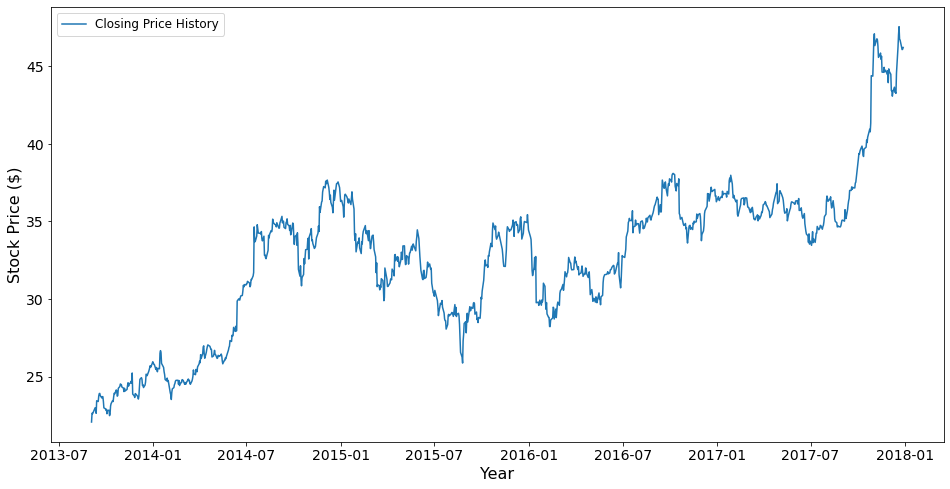

In [12]:
plt.figure(figsize = (16,8))
plt.plot(df['Date'], df['Close'], label = 'Closing Price History')
plt.legend(loc = "upper left")
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.show()

#### Split data into training and testing data
Before we begin our modelling, we will split our dataset into training and testing data.

For time series forecasting, we cannot use random split to split our data, this is because it will destory the time component of the data. We will set earlier 80% of data to training dataset and remaining 20% data to testing dataset.

In [13]:
test_size = 0.2
training_size = 1 - test_size

test_num = int(test_size * len(df))
train_num = int(training_size * len(df))

print("train_num: " + str(train_num))
print("test_num: " + str(test_num))

train_num: 872
test_num: 218


In [14]:
train = df[:train_num][['Date', 'Close']]
test = df[train_num:][['Date', 'Close']]

### Moving Average Algorithm

In [15]:
preds = []

for i in range(0, test.shape[0]):
    a = train['Close'][len(train) - test.shape[0] + i:].sum() + test['Close'][:i].sum()
    b = a/test.shape[0]
    preds.append(b)

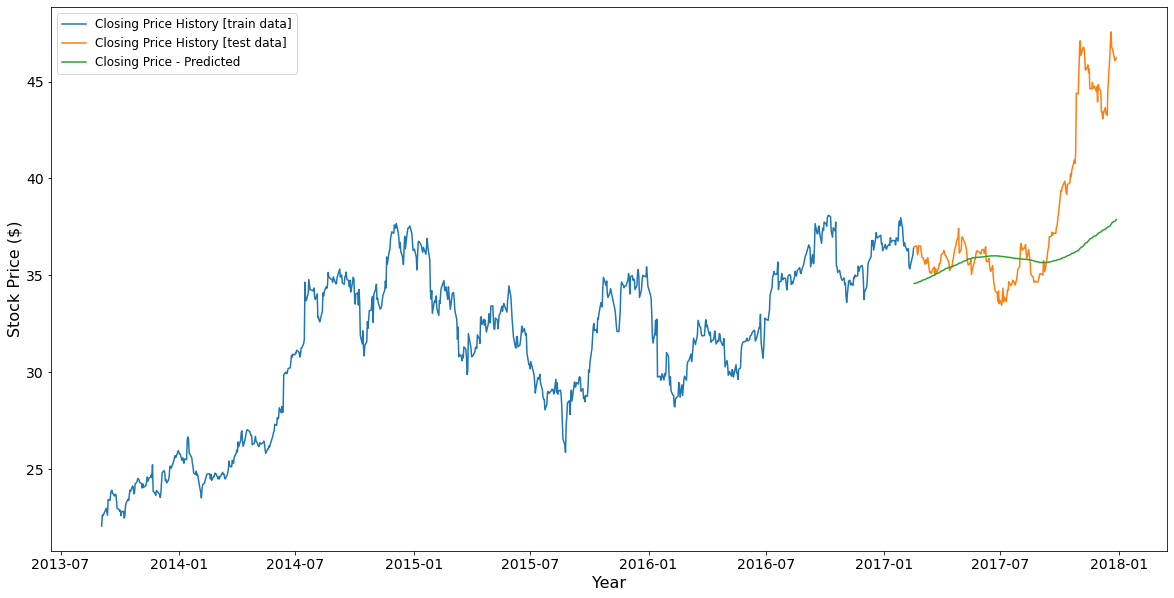

In [16]:
# Plot predicted price vs actual closing price 

test['Predictions_ma'] = preds
plt.figure(figsize = (20,10))
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.plot(train['Date'], train['Close'], label = 'Closing Price History [train data]')
plt.plot(test['Date'], test['Close'], label = 'Closing Price History [test data]')
plt.plot(test['Date'], test['Predictions_ma'], label = 'Closing Price - Predicted')
plt.legend(loc = "upper left")
plt.show()

In [17]:
# Evaluate performance
rmse_ma = get_rmse(np.array(test['Close']), np.array(test['Predictions_ma']))
print('Root Mean Squared Error: ' + str(rmse_ma))
mape_ma = get_mape(np.array(test['Close']), np.array(test['Predictions_ma']))
print('Mean Absolute Percentage Error (%): ' + str(mape_ma))

Root Mean Squared Error: 3.9597817916358133
Mean Absolute Percentage Error (%): 6.175502851776837


### LSTM Algorithm
Long Short Term Memory (LSTM)

Standardise all our feature variables to the same scale

In [18]:
# scale our dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])
scaled_data_train = scaled_data[:train.shape[0]]

In [19]:
# create a useful function to split our data into X and y

def get_x_y(data, N, offset):
    """
    Split data into input variable (X) and output variable (y)
    
    INPUT:
    data - dataset to be splitted
    N - time frame to be used
    offset - position to start the split
    
    OUTPUT:
    X - input variable
    y - output variable
    """
    X, y = [], []
    
    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [20]:
# we use past 60 days stock prices for our training to predict 61th day's closing price.

X_train, y_train = get_x_y(scaled_data_train, 60, 60)

#### Create LSTM Network

In [21]:
# initial LSTM parameters
lstm_units = 50 
optimizer = 'adam'
epochs = 1
batch_size = 1

model = Sequential()
model.add(LSTM(units = lstm_units, return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(LSTM(units = lstm_units))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
# Compile and fit the LSTM network
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 39s - loss: 0.0033


In [23]:
# predict stock prices using past 60 stock prices
inputs = df['Close'][len(df) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

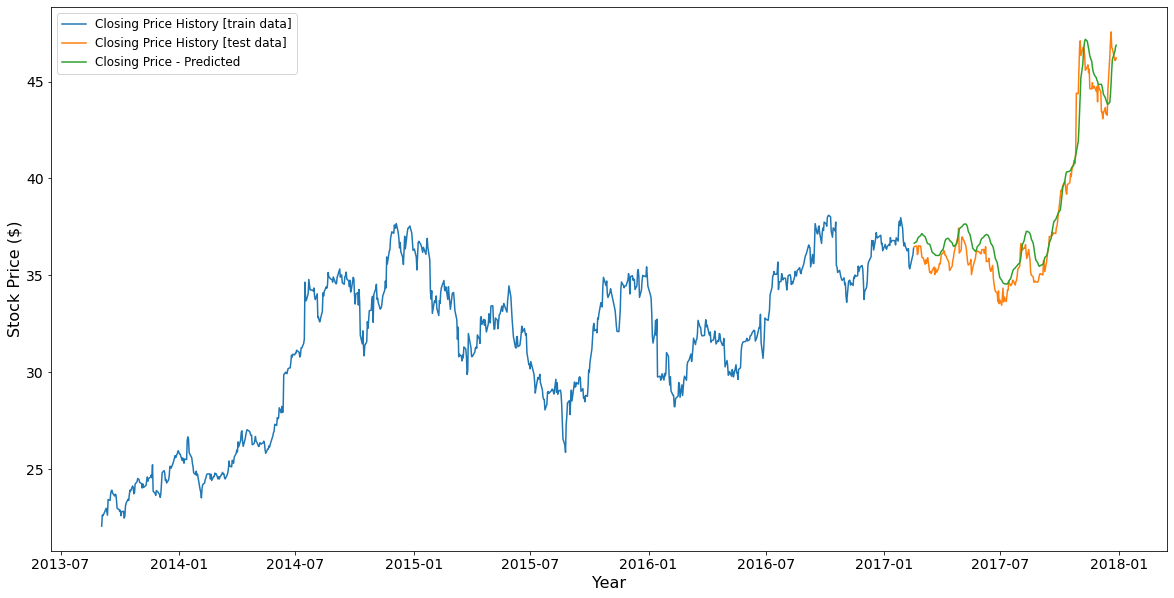

In [24]:
# Plot predicted price vs actual closing price 

test['Predictions_lstm'] = closing_price
plt.figure(figsize = (20,10))
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.plot(train['Date'], train['Close'], label = 'Closing Price History [train data]')
plt.plot(test['Date'], test['Close'], label = 'Closing Price History [test data]')
plt.plot(test['Date'], test['Predictions_lstm'], label = 'Closing Price - Predicted')
plt.legend(loc = "upper left")
plt.show()

In [25]:
# Evaluate performance
rmse_lstm = get_rmse(np.array(test['Close']), np.array(test['Predictions_lstm']))
mape_lstm = get_mape(np.array(test['Close']), np.array(test['Predictions_lstm']))
print('Root Mean Squared Error: ' + str(rmse_lstm))
print('Mean Absolute Percentage Error (%): ' + str(mape_lstm))

Root Mean Squared Error: 1.0450523122349074
Mean Absolute Percentage Error (%): 2.24177825849715


### Model Performance Comparison 

In [26]:
d = {'Metric':['RMSE','MAPE (%)'],
     'Moving Average': [rmse_ma, mape_ma],
     'LSTM': [rmse_lstm, mape_lstm]
    
}

comp_table = pd.DataFrame(d)
comp_table

,Metric,Moving Average,LSTM
0,RMSE,3.959782,1.045052
1,MAPE (%),6.175503,2.241778


Wining Model: **LSTM**

### Tune Hyperparameters for LSTM
Let's create some functions based on the codes above to help us feed our specific hyperparameters into LSTM model and get RMSE and MAPE with only a few lines of codes.

In [27]:
# create, compile and fit LSTM netork.
def fit_lstm(X_train, y_train, lstm_units = 50, optimizer = 'adam', epochs = 1, 
             batch_size = 1, loss = 'mean_squared_error'):
    """
    INPUT:
    X_train - training input variables (X)
    y_train - training output variable (y)
    
    default(initial) parameters chosen for LSTM
    --------------------------------------------
    lstm_units = 50
    optimizer = 'adam'
    epochs = 1
    batch_size = 1
    loss = 'mean_squared_error'
    
    OUTPUT:
    model - fitted model
    """
    model = Sequential()
    model.add(LSTM(units = lstm_units, return_sequences = True, input_shape = (X_train.shape[1],1)))
    model.add(LSTM(units = lstm_units))
    model.add(Dense(1))
    
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 1)
    # verbose changed to 1 to show the animated progress...
    return model

# predict stock price using past 60 stock prices
def get_pred_closing_price(df, scaler, model):
    """
    INPUT:
    df - dataframe that has been preprocessed
    scaler - instantiated object for MixMaxScaler()
    model - fitted model
    
    OUTPUT:
    closing_price - predicted closing price using fitted model
    """
    inputs = df['Close'][len(df) - len(test) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs = scaler.transform(inputs)

    X_test = []
    for i in range(60, inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    return closing_price

# evaluate model performance
def model_performance(test, closing_price):
    """
    INPUT:
    test - test dataset that contains only 'Date' & 'Close' columns (i.e.test = df[train_num:][['Date', 'Close']])
    closing_price - predicted closing price using fitted model
    
    OUTPUT:
    rmse_lstm - RMSE for LSTM
    mape_lstm - MAPE(%) for LSTM
    """
    test['Predictions_lstm_tuned'] = closing_price
    rmse_lstm = get_rmse(np.array(test['Close']), np.array(test['Predictions_lstm_tuned']))
    mape_lstm = get_mape(np.array(test['Close']), np.array(test['Predictions_lstm_tuned']))
    print('Root Mean Squared Error: ' + str(rmse_lstm))
    print('Mean Absolute Percentage Error (%): ' + str(mape_lstm))
    return rmse_lstm, mape_lstm

#================================================================================
# train, predict, evaluate model
def train_pred_eval_model(X_train, y_train, df, scaler, test, 
                          lstm_units = 50, optimizer = 'adam', epochs = 1, 
                          batch_size = 1, loss = 'mean_squared_error'):
    """
    INPUT:
    X_train - training input variables (X)
    y_train - training output variable (y)
    df - dataframe that has been preprocessed
    scaler - instantiated object for MixMaxScaler()
    test - test dataset that contains only 'Date' & 'Close' columns (i.e.test = df[train_num:][['Date', 'Close']])
    
    default(initial) parameters chosen for LSTM
    --------------------------------------------
    lstm_units = 50
    optimizer = 'adam'
    epochs = 1
    batch_size = 1
    loss = 'mean_squared_error'
    
    OUTPUT:
    rmse_lstm - RMSE for LSTM
    mape_lstm - MAPE(%) for LSTM    
    """
    model_tuned = fit_lstm(X_train, y_train, int(lstm_units), optimizer, int(epochs), 
             int(batch_size), loss)
    closing_price_tuned = get_pred_closing_price(df, scaler, model_tuned)
    rmse_lstm, mape_lstm = model_performance(test, closing_price_tuned)
    return rmse_lstm, mape_lstm

### Tune Model - epochs
The first LSTM parameter that we can tune is the number of training epochs.

One epoch is when the dataset is passed forward and backward through the Neural Network once, two is twice, so on and so fort...

There is no right numbers of epochs. Different datasets need different numbers of epochs.

Reference: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

In [28]:
# Test epochs range from 1 to 4 using a for loop, print the RMSE and MAPE results and store results in a dataframe
# the rest of the lstm parameters are the initial paramaters

epoch_ls, rmse_ls, mape_ls = [], [], []

epochs_range = [1, 2, 3, 4]
for i in epochs_range:
    print('epochs = '+ str(i))
    print('============')
    rmse_lstm, mape_lstm = train_pred_eval_model(X_train, y_train, df, scaler, test, epochs = i)
    
    epoch_ls.append(i)
    rmse_ls.append(rmse_lstm)
    mape_ls.append(mape_lstm)
    
    print(" ")

col_names = ['Epoch', 'RMSE', 'MAPE']
df_epoch = pd.DataFrame(list(zip(epoch_ls, rmse_ls, mape_ls)),
                       columns = col_names)

epochs = 1
Epoch 1/1
812/812 [==============================] - 60s 74ms/step - loss: 0.0030
Root Mean Squared Error: 1.2007355204075025
Mean Absolute Percentage Error (%): 2.062681543373996
 
epochs = 2
Epoch 1/2
812/812 [==============================] - 49s 60ms/step - loss: 0.0030
Epoch 2/2
812/812 [==============================] - 57s 70ms/step - loss: 0.0012
Root Mean Squared Error: 0.971991569110762
Mean Absolute Percentage Error (%): 1.6159223065422803
 
epochs = 3
Epoch 1/3
812/812 [==============================] - 48s 59ms/step - loss: 0.0032
Epoch 2/3
812/812 [==============================] - 45s 56ms/step - loss: 0.0011
Epoch 3/3
812/812 [==============================] - 45s 55ms/step - loss: 8.0655e-04 0s - loss: 8.117
Root Mean Squared Error: 0.7285558512202821
Mean Absolute Percentage Error (%): 1.6104394906966353
 
epochs = 4
Epoch 1/4
812/812 [==============================] - 48s 60ms/step - loss: 0.0034
Epoch 2/4
812/812 [==============================] - 49s 60m

In [29]:
# results in dataframe
df_epoch

,Epoch,RMSE,MAPE
0,1,1.200736,2.062682
1,2,0.971992,1.615922
2,3,0.728556,1.610439
3,4,1.010704,2.137765


Winner epochs = **3**

### Tune Model - batch size
Batch size is total number of training examples present in a single batch. We cannot pass the entire dataset into the neural network at once, so we divide dataset into number of batches.

Reference: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

In [30]:
# Test batch_size range from 1 to 4 using a for loop and print the RMSE and MAPE results, and store results in a dataframe
# the rest of the lstm parameters are the initial paramaters

batch_size_ls, rmse_ls, mape_ls = [], [], []

batch_size_range = [1, 2, 3, 4]
for i in batch_size_range:
    print('batch_size = '+ str(i))
    print('==============')
    rmse_lstm, mape_lstm = train_pred_eval_model(X_train, y_train, df, scaler, test, batch_size = i)
    
    batch_size_ls.append(i)
    rmse_ls.append(rmse_lstm)
    mape_ls.append(mape_lstm)
    
    print(" ")

col_names = ['Batch Size', 'RMSE', 'MAPE']
df_batch_size = pd.DataFrame(list(zip(batch_size_ls, rmse_ls, mape_ls)),
                       columns = col_names)

# results in dataframe
df_batch_size

batch_size = 1
Epoch 1/1
812/812 [==============================] - 41s 51ms/step - loss: 0.0029 
Root Mean Squared Error: 1.347579609830661
Mean Absolute Percentage Error (%): 2.303912114268294
 
batch_size = 2
Epoch 1/1
812/812 [==============================] - 27s 33ms/step - loss: 0.0044 0s - lo
Root Mean Squared Error: 1.6000647735976528
Mean Absolute Percentage Error (%): 3.010526622073342
 
batch_size = 3
Epoch 1/1
812/812 [==============================] - 18s 23ms/step - loss: 0.0062 0s - loss: 0.006
Root Mean Squared Error: 1.2338066501551688
Mean Absolute Percentage Error (%): 2.1254869108692103
 
batch_size = 4
Epoch 1/1
812/812 [==============================] - 14s 17ms/step - loss: 0.0066
Root Mean Squared Error: 1.3683662190434818
Mean Absolute Percentage Error (%): 2.430806290142973
 


,Batch Size,RMSE,MAPE
0,1,1.347580,2.303912
1,2,1.600065,3.010527
2,3,1.233807,2.125487
3,4,1.368366,2.430806


Winner batch size = **3**

### Tune model - optimizer
Optimisers play a crucial role in increasing the accuracy of the model.

There are many different optimizer available to choose. In short, RMSProp, AdaDelta and Adam are very similar algorithm and since Adam was found to slightly outperform RMSProp, Adam is generally chosen as the best overall choice.

Reference: https://deepdatascience.wordpress.com/2016/11/18/which-lstm-optimizer-to-use/


In [31]:
# Test some of the different optimizer using a for loop and print the RMSE and MAPE results, and store results in a dataframe
# the rest of the lstm parameters are the initial paramaters

opt_ls, rmse_ls, mape_ls = [], [], []

optimizer_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
for i in optimizer_list:
    print('optimizer = '+ str(i))
    print('=====================')
    rmse_lstm, mape_lstm = train_pred_eval_model(X_train, y_train, df, scaler, test, optimizer = i)
    
    opt_ls.append(i)
    rmse_ls.append(rmse_lstm)
    mape_ls.append(mape_lstm)
    
    print(" ")

col_names = ['Optimizer', 'RMSE', 'MAPE']
df_opt = pd.DataFrame(list(zip(opt_ls, rmse_ls, mape_ls)),
                       columns = col_names)

# results in dataframe
df_opt

optimizer = adam
Epoch 1/1
812/812 [==============================] - 46s 57ms/step - loss: 0.0027 0s - loss
Root Mean Squared Error: 1.4313693920361965
Mean Absolute Percentage Error (%): 2.599009765415091
 
optimizer = sgd
Epoch 1/1
812/812 [==============================] - 49s 60ms/step - loss: 0.0026
Root Mean Squared Error: 0.9110662372793832
Mean Absolute Percentage Error (%): 1.508990480183769
 
optimizer = rmsprop
Epoch 1/1
812/812 [==============================] - 50s 62ms/step - loss: 0.0027
Root Mean Squared Error: 1.4464623801109247
Mean Absolute Percentage Error (%): 2.709685827709293
 
optimizer = adagrad
Epoch 1/1
812/812 [==============================] - 54s 67ms/step - loss: 0.0027
Root Mean Squared Error: 1.2336679810118192
Mean Absolute Percentage Error (%): 2.159142181489781
 
optimizer = adadelta
Epoch 1/1
812/812 [==============================] - 54s 67ms/step - loss: 0.0032
Root Mean Squared Error: 1.0589025447829417
Mean Absolute Percentage Error (%): 2.2595

,Optimizer,RMSE,MAPE
0,adam,1.431369,2.599010
1,sgd,0.911066,1.508990
2,rmsprop,1.446462,2.709686
3,adagrad,1.233668,2.159142
4,adadelta,1.058903,2.259555
5,adamax,0.822685,1.420364
6,nadam,1.070004,1.747760


Winner optimizer = **adamax**

In [28]:
# combine winning parameters and re-train our LSTM model

epochs = 3
batch_size = 3
optimizer = 'adamax'

rmse_lstm_tuned, mape_lstm_tuned = train_pred_eval_model(X_train, y_train, df, scaler, test, epochs = 3, 
                                             batch_size = 3, optimizer = 'adamax')

Epoch 1/3
812/812 [==============================] - 16s 19ms/step - loss: 0.0052
Epoch 2/3
812/812 [==============================] - 14s 18ms/step - loss: 0.0015
Epoch 3/3
812/812 [==============================] - 16s 19ms/step - loss: 0.0013
Root Mean Squared Error: 0.981730969015777
Mean Absolute Percentage Error (%): 1.6226573320198385


In [29]:
# model comparison before and after LTSM is tuned
comp_table_2 = comp_table.drop('Moving Average', axis = 1)
comp_table_2['LSTM_tuned'] = [rmse_lstm_tuned, mape_lstm_tuned]

In [30]:
comp_table_2

,Metric,LSTM,LSTM_tuned
0,RMSE,1.045052,0.981731
1,MAPE (%),2.241778,1.622657
